# Install required dependency

In [ ]:
# sudo apt -y install libportaudio2
!pip install tflite-support
!pip install tflite-model-maker

# if using different python environment apt install python3.*-dev first
!pip install pycocotools

In [2]:
!pip list | grep tflite

!pip list | grep pycocotools

tflite-model-maker            0.4.2         /home/lu/Desktop/will/jupyter/examples/tensorflow_examples/lite/model_maker/pip_package/src
tflite-support                0.4.3


# 1. Prepare Dataset images in JPEG

In [ ]:
import os,shutil

target_dir = r"tflite_data/trainingObj/train"

# print all files under target_dir path
for root,dirs,files in os.walk(target_dir):
  for filename in files:
    print(filename)

In [ ]:
# shuffle files
# from random import shuffle
# from glob import glob
# files = glob(r"tflite_data/trainingObj/converted/train/*.jpg")
# shuffle(files)

# for file in files:
  # ...

In [ ]:
### remove files such as .txt in training dataset folders
targetDir = r"tflite_data/trainingObj/"

for root,dirs,files in os.walk(targetDir):
  for filename in files:
    base,extension = os.path.splitext(filename)
    if(extension == ".txt"):
      remove_name = os.path.join(os.path.abspath(root),filename)
      os.remove(remove_name)

### **Danger, do only once**: slice 8:1:1, train images, validate images, test images

In [ ]:
import os,shutil,re

val_dir = r"tflite_data/trainingObj/validate"
test_dir = r"tflite_data/trainingObj/test"
train_dir = r"tflite_data/trainingObj/train"

# toogle the movdir,and targetDir to meet your expectations
mov_dir = val_dir
target_dir = test_dir

# move .jpg and .xml from movdir to targetDir
for root,dirs,files in os.walk(mov_dir):
  i = 0
  count = 0
  for filename in files:
    
    #extract file base name
    base,extension = os.path.splitext(filename)
    xml_filename=base+".xml"
    old_name = os.path.join(os.path.abspath(root),filename)
    old_name_xml = os.path.join(os.path.abspath(root),xml_filename)

    # 2/10 images with extension ".jpg" is move to target folder
    if(i != 0 and extension == ".jpg" and i%2 == 0):
      new_name_jpg = os.path.join(target_dir,filename)
      new_name_xml = os.path.join(target_dir,xml_filename)

      # print(count, new_name_xml)
      
      # move file to validate
      if not (
        os.path.exists(os.path.join(target_dir)) and 
        os.path.exists(os.path.join(mov_dir))         
      ):
        print(os.path.join(target_dir),"or ",os.path.join(mov_dir)," not found")
        continue

      elif not (
          os.path.exists(new_name_jpg) or
          os.path.exists(new_name_xml)
      ):
        shutil.move(old_name,new_name_jpg)
        shutil.move(old_name_xml,new_name_xml)
        print("move: ",count, old_name, "and ", old_name_xml)
      else:
        print("Already exists: ", new_name_jpg,"or", new_name_xml)
      
      i+=1
      count+=1
    elif(extension == ".jpg"):
      i+=1

In [ ]:
# count list images with .jpg in target path
!ls -lR tflite_data/trainingObj/converted/train/*.jpg | wc -l
!ls -lR tflite_data/trainingObj/converted/validate/*.jpg | wc -l
!ls -lR tflite_data/trainingObj/converted/test/*.jpg | wc -l

# 2.Training Process

In [1]:
import numpy as np
import os

from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
# from tflite_model_maker import image_classifier
# from tflite_model_maker.image_classifier import DataLoader
from tflite_model_maker.config import ExportFormat, QuantizationConfig

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/home/lu/.local/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
train_data = object_detector.DataLoader.from_pascal_voc(
    'tflite_data/trainingObj/converted/train',
    'tflite_data/trainingObj/train',
    ['masked','unmasked']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    'tflite_data/trainingObj/converted/validate',
    'tflite_data/trainingObj/validate',
    ['masked','unmasked']
)

test_data = object_detector.DataLoader.from_pascal_voc(
    'tflite_data/trainingObj/converted/test',
    'tflite_data/trainingObj/test',
    ['masked','unmasked']
)

# Select model architecture

In [3]:
spec = model_spec.get('efficientdet_lite0')

2023-03-14 11:07:25.109843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 11:07:25.127918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 11:07:25.128058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 11:07:25.128927: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Load the dataset (deprecated, for image classifier not object_dectector)

In [ ]:
# data = DataLoader.from_folder("tflite_data/trainingObj/")
# train_data, rest_data = data.split(0.8)
# validation_data, test_data = rest_data.split(0.5)

#**Model training **

In [8]:
# model = image_classifier.create(train_data,validation_data=validation_data)

obj_detector_model = object_detector.create(train_data,model_spec=spec,validation_data=val_data,epochs=60,batch_size=8,train_whole_model=True)



Epoch 1/60
17/17 [==============================] - 26s 823ms/step - det_loss: 1.6265 - cls_loss: 1.0342 - box_loss: 0.0118 - reg_l2_loss: 0.0630 - loss: 1.6895 - learning_rate: 0.0438 - gradient_norm: 0.9290 - val_det_loss: 1.5251 - val_cls_loss: 1.0992 - val_box_loss: 0.0085 - val_reg_l2_loss: 0.0630 - val_loss: 1.5881
Epoch 2/60
17/17 [==============================] - 12s 736ms/step - det_loss: 0.7679 - cls_loss: 0.4102 - box_loss: 0.0072 - reg_l2_loss: 0.0631 - loss: 0.8310 - learning_rate: 0.0799 - gradient_norm: 1.5128 - val_det_loss: 1.4089 - val_cls_loss: 0.5757 - val_box_loss: 0.0167 - val_reg_l2_loss: 0.0632 - val_loss: 1.4721
Epoch 3/60
17/17 [==============================] - 13s 752ms/step - det_loss: 0.5030 - cls_loss: 0.2777 - box_loss: 0.0045 - reg_l2_loss: 0.0633 - loss: 0.5663 - learning_rate: 0.0796 - gradient_norm: 1.4715 - val_det_loss: 0.9428 - val_cls_loss: 0.5355 - val_box_loss: 0.0081 - val_reg_l2_loss: 0.0634 - val_loss: 1.0062
Epoch 4/60
17/17 [=============

# examine trained model if any

In [12]:
#Evaluate 
obj_detector_model.evaluate(test_data)

#Export model
obj_detector_model.export(export_dir=".")

3/3 [==============================] - 7s 1s/step



2023-03-14 13:07:51.616139: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-03-14 13:08:00.600700: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2023-03-14 13:08:05.471563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-03-14 13:08:05.471581: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-03-14 13:08:05.472105: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpgwk_96ok
2023-03-14 13:08:05.514292: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-03-14 13:08:05.514313: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if pre

In [ ]:
obj_detector_model.evaluate_tflite('model.tflite',test_data)

NameError: ignored

In [ ]:
obj_detector_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________


# Test trained model and define visualization functions

In [ ]:
# import tensorflow as tf
# import os

# train_data_dir = 'tflite_data/trainingObj'

# label_map = {}
# for i,class_name in enumerate(sorted(os.listdir(train_data_dir))):
#   label_map[class_name] = i

# for label_name,label_id in label_map.items():
#   print(label_id, label_name)

# print(label_map)

In [13]:
import cv2

from PIL import Image

model_path = 'model.tflite'

model=obj_detector_model

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  scores = get_output_tensor(interpreter, 0)
  boxes = get_output_tensor(interpreter, 1)
  count = int(get_output_tensor(interpreter, 2))
  classes = get_output_tensor(interpreter, 3)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

# Test Sample Image with trained Model

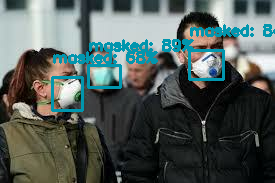

In [15]:
from PIL import Image
import tensorflow as tf

INPUT_IMAGE_URL =  "tflite_data/trainingObj/converted/test/masked (1863).jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    INPUT_IMAGE_URL, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


# 3. Compile with EdgeTPU

In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

!sudo apt-get update

!sudo apt-get install edgetpu-compiler

In [ ]:
edgetpu_compiler model.tflite --num_segments=1